
# Sentiment Analysis — Baselines, Few-Shot LLM & Error Analysis

Questo notebook implementa:
1) **Baselines**: VADER e TF-IDF + Logistic Regression  
2) **Few-shot LLM**: classificazione NEG/POS via prompt engineering  
3) **Valutazione comparata**: Accuracy, F1, Confusion Matrix  
4) **Analisi dell'errore**: confronto tra i tre modelli, estrazione esempi difficili  
5) **Spiegazioni via LLM**: per i casi complessi, il modello prova a motivare l'errore (sarcasmo, ambiguità, bias, slang)


In [1]:

# ====================== Setup & Install ======================
!pip -q install -U datasets nltk scikit-learn google-generativeai matplotlib > /dev/null

import os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from datasets import load_dataset
import nltk
nltk.download("vader_lexicon", quiet=True)
from nltk.sentiment import SentimentIntensityAnalyzer

# Opzionale: Google Gemini per few-shot
try:
    import google.generativeai as genai
except Exception:
    genai = None

SEED = 42
random.seed(SEED); np.random.seed(SEED)
plt.rcParams["figure.figsize"] = (4.5, 4.5)


## 1) Dataset: `mteb/amazon_polarity` — subsampling controllato

In [ ]:

# ====================== Data Loading ======================
# Etichette: 0 = NEG, 1 = POS
ds = load_dataset("mteb/amazon_polarity")

TRAIN_FRAC = 0.01
TEST_FRAC  = 0.10
SEED = 42

train_sub = ds["train"].train_test_split(train_size=TRAIN_FRAC, seed=SEED)["train"]
test_sub  = ds["test"].train_test_split(train_size=TEST_FRAC,  seed=SEED)["train"]

train = train_sub.to_pandas()[["text", "label"]].rename(columns={"label":"y"}).dropna()
test  = test_sub.to_pandas()[["text", "label"]].rename(columns={"label":"y"}).dropna()

print("Train size:", len(train), "| Test size:", len(test))
print("Train label balance:\n", train["y"].value_counts(normalize=True).round(3))
print("Test label balance:\n",  test["y"].value_counts(normalize=True).round(3))


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

data/train-00001-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

data/train-00002-of-00004.parquet:   0%|          | 0.00/251M [00:00<?, ?B/s]

data/train-00003-of-00004.parquet:   0%|          | 0.00/250M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3599994 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Train size: 35999 | Test size: 40000
Train label balance:
 y
1    0.5
0    0.5
Name: proportion, dtype: float64
Test label balance:
 y
0    0.502
1    0.498
Name: proportion, dtype: float64


## 2) Utilità: metriche e Confusion Matrix

In [ ]:

import numpy as np
from typing import List

LABELS = [0, 1]  # 0=NEG, 1=POS
LABEL2TXT = {0:"NEG", 1:"POS"}

def evaluate_predictions(y_true: np.ndarray, y_pred: np.ndarray, title: str = "Model"):
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    print(f"\n=== {title} ===")
    print("Accuracy:", round(acc, 4))
    print("F1-macro:", round(f1, 4))
    print(classification_report(y_true, y_pred, digits=3))
    plot_confusion_matrix(y_true, y_pred, labels=LABELS, title=f"{title} — Confusion Matrix")

def plot_confusion_matrix(y_true, y_pred, labels=LABELS, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots()
    im = ax.imshow(cm)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(np.arange(len(labels))); ax.set_xticklabels([LABEL2TXT[l] for l in labels], rotation=0)
    ax.set_yticks(np.arange(len(labels))); ax.set_yticklabels([LABEL2TXT[l] for l in labels])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.show()


## 3) Baseline 1 — VADER


=== VADER ===
Accuracy: 0.7216
F1-macro: 0.7104
              precision    recall  f1-score   support

           0      0.871     0.523     0.654     20095
           1      0.657     0.922     0.767     19905

    accuracy                          0.722     40000
   macro avg      0.764     0.723     0.710     40000
weighted avg      0.765     0.722     0.710     40000



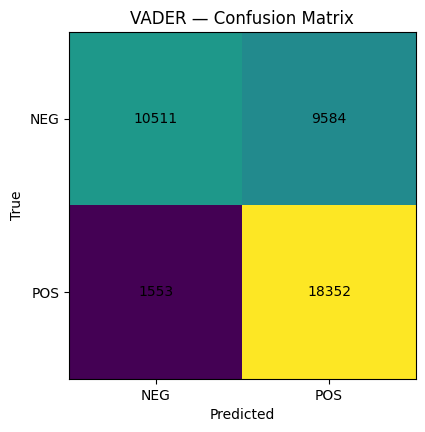

In [ ]:

sia = SentimentIntensityAnalyzer()

def vader_predict(texts: List[str]) -> np.ndarray:
    preds = []
    for t in texts:
        s = sia.polarity_scores(t)["compound"]
        preds.append(1 if s >= 0.05 else 0)  # 1=POS, 0=NEG
    return np.array(preds, dtype=int)

pred_vader = vader_predict(test["text"].tolist())
evaluate_predictions(test["y"].values, pred_vader, title="VADER")


## 4) Baseline 2 — TF-IDF + Logistic Regression


=== TF-IDF + LogisticRegression ===
Accuracy: 0.9054
F1-macro: 0.9054
              precision    recall  f1-score   support

           0      0.904     0.908     0.906     20095
           1      0.907     0.902     0.905     19905

    accuracy                          0.905     40000
   macro avg      0.905     0.905     0.905     40000
weighted avg      0.905     0.905     0.905     40000



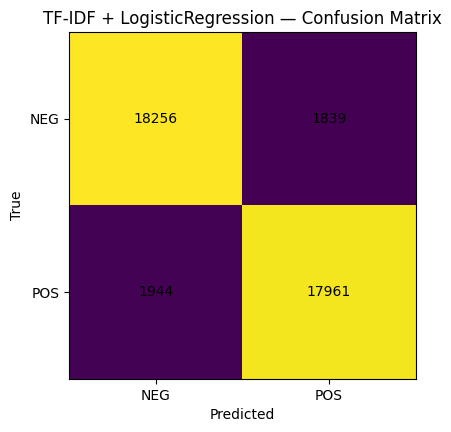


Top POS terms:
great  (15.145)
excellent  (9.635)
perfect  (7.770)
good  (7.747)
awesome  (7.694)
best  (7.674)
amazing  (7.324)
love  (6.524)
easy  (6.104)
wonderful  (6.092)
well  (5.763)
the best  (5.462)
must  (5.403)
fun  (5.266)
highly  (5.061)

Top NEG terms:
not  (-13.223)
boring  (-9.437)
poor  (-9.344)
disappointed  (-8.943)
disappointing  (-8.693)
worst  (-7.786)
bad  (-7.252)
waste  (-6.818)
terrible  (-6.812)
not worth  (-6.760)
money  (-6.349)
horrible  (-6.319)
nothing  (-6.237)
disappointment  (-6.199)
awful  (-6.028)


In [ ]:

tfidf_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        min_df=3,
        ngram_range=(1, 2),
        max_features=120_000,
        lowercase=True,
        strip_accents=None
    )),
    ("clf", LogisticRegression(
        max_iter=300,
        class_weight="balanced",
        C=2.0,
        solver="liblinear"
    ))
])

tfidf_lr.fit(train["text"], train["y"])
pred_tfidf = tfidf_lr.predict(test["text"])
evaluate_predictions(test["y"].values, pred_tfidf, title="TF-IDF + LogisticRegression")

def top_tfidf_weights(model, top_k=15):
    vec = model.named_steps["tfidf"]
    clf = model.named_steps["clf"]
    feature_names = np.array(vec.get_feature_names_out())
    coefs = clf.coef_[0]
    top_pos_idx = np.argsort(coefs)[-top_k:][::-1]
    top_neg_idx = np.argsort(coefs)[:top_k]

    print("\nTop POS terms:")
    for i in top_pos_idx:
        print(f"{feature_names[i]}  ({coefs[i]:.3f})")

    print("\nTop NEG terms:")
    for i in top_neg_idx:
        print(f"{feature_names[i]}  ({coefs[i]:.3f})")

top_tfidf_weights(tfidf_lr, top_k=15)


## 5) Baseline 3 — Few-shot LLM (Gemini)

In [ ]:

USE_GEMINI = True
MODEL_NAME = "gemini-2.5-flash-lite"

GEMINI_API_KEY = os.environ.get("GEMINI_API_KEY", None)
if USE_GEMINI and genai is not None:
    try:
        if not GEMINI_API_KEY:
            from getpass import getpass
            GEMINI_API_KEY = getpass("Inserisci GEMINI_API_KEY: ")
        genai.configure(api_key=GEMINI_API_KEY)
        model = genai.GenerativeModel(MODEL_NAME)
    except Exception as e:
        print("Gemini non configurato correttamente:", e)
        USE_GEMINI = False
else:
    USE_GEMINI = False
    print("Gemini non disponibile: modulo mancante o disabilitato.")

INSTRUCTIONS = (
    "Sei un classificatore di sentiment. Rispondi SOLO con una delle etichette: NEG o POS.\n"
    "Esempi:\n"
    "- \"Questo prodotto è terribile, mai più\" -> NEG\n"
    "- \"Sono soddisfatto dell'acquisto, consigliato!\" -> POS\n"
    "Testo:"
)

def llm_predict_gemini(texts, batch_size=8, temperature=0.0):
    if not USE_GEMINI:
        print("LLM disabilitato, restituisco predizioni casuali come placeholder.")
        return np.random.randint(0, 2, size=len(texts))

    preds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        for t in batch:
            prompt = INSTRUCTIONS + f' "{t}"'
            try:
                out = model.generate_content(prompt, generation_config={"temperature": temperature, "max_output_tokens": 4})
                ans = (out.text or "").strip().upper()
                if "NEG" in ans and "POS" in ans:
                    ans = "NEG" if ans.index("NEG") < ans.index("POS") else "POS"
                if "NEG" in ans:
                    preds.append(0)
                elif "POS" in ans:
                    preds.append(1)
                else:
                    preds.append(0)
            except Exception as e:
                preds.append(0)
    return np.array(preds, dtype=int)

pred_llm = llm_predict_gemini(test["text"].tolist(), batch_size=8, temperature=0.0)
evaluate_predictions(test["y"].values, pred_llm, title="Few-shot LLM (Gemini)")


KeyboardInterrupt: Interrupted by user

## 6) Confronto modelli & Analisi degli errori

In [ ]:

eval_df = pd.DataFrame({
    "text": test["text"].tolist(),
    "y_true": test["y"].tolist(),
    "pred_vader": pred_vader.tolist(),
    "pred_tfidf": pred_tfidf.tolist(),
    "pred_llm":   pred_llm.tolist()
})

eval_df["ok_vader"] = (eval_df["y_true"] == eval_df["pred_vader"]).astype(int)
eval_df["ok_tfidf"] = (eval_df["y_true"] == eval_df["pred_tfidf"]).astype(int)
eval_df["ok_llm"]   = (eval_df["y_true"] == eval_df["pred_llm"]).astype(int)

discord = eval_df[(eval_df["pred_vader"] != eval_df["pred_tfidf"]) |
                  (eval_df["pred_llm"] != eval_df["pred_tfidf"]) |
                  (eval_df["pred_llm"] != eval_df["pred_vader"])]

print("Numero di esempi discordanti:", len(discord))

def where_model_fails(df, model_col):
    other_models = ["pred_vader", "pred_tfidf", "pred_llm"]
    other_models = [m for m in other_models if m != model_col]
    mask_fail = df[model_col] != df["y_true"]
    mask_others_ok = True
    for m in other_models:
        mask_others_ok = mask_others_ok & (df[m] == df["y_true"])
    return df[mask_fail & mask_others_ok]

fails_vader = where_model_fails(eval_df, "pred_vader").head(20)
fails_tfidf = where_model_fails(eval_df, "pred_tfidf").head(20)
fails_llm   = where_model_fails(eval_df, "pred_llm").head(20)

print("\nEsempi in cui fallisce SOLO VADER (prime 20):", len(fails_vader))
display(fails_vader[["text","y_true","pred_vader","pred_tfidf","pred_llm"]])

print("\nEsempi in cui fallisce SOLO TF-IDF (prime 20):", len(fails_tfidf))
display(fails_tfidf[["text","y_true","pred_vader","pred_tfidf","pred_llm"]])

print("\nEsempi in cui fallisce SOLO LLM (prime 20):", len(fails_llm))
display(fails_llm[["text","y_true","pred_vader","pred_tfidf","pred_llm"]])

eval_df.to_csv("/mnt/data/predictions_all_models.csv", index=False)
discord.to_csv("/mnt/data/predictions_discord.csv", index=False)
print("\nSalvati: /mnt/data/predictions_all_models.csv e /mnt/data/predictions_discord.csv")


## 7) Spiegazioni LLM per esempi difficili (sarcasmo, ambiguità, bias)

In [ ]:

ASK_EXPLANATIONS = True  # metti False per saltare

def ask_llm_explanations(rows, max_items=10):
    if not (USE_GEMINI and genai and ASK_EXPLANATIONS):
        print("Spiegazioni disabilitate o LLM non configurato.")
        return pd.DataFrame()

    out_rows = []
    for _, row in rows.head(max_items).iterrows():
        ytxt = LABEL2TXT.get(row['y_true'], row['y_true'])
        pv = LABEL2TXT.get(row['pred_vader'], row['pred_vader'])
        pt = LABEL2TXT.get(row['pred_tfidf'], row['pred_tfidf'])
        pl = LABEL2TXT.get(row['pred_llm'], row['pred_llm'])

        prompt = (
            "Sei un linguista computazionale. Analizza il seguente esempio di sentiment.\n"
            f"- Testo: \"\"\"{row['text']}\"\"\"\n"
            f"- Etichetta corretta: {ytxt}\n"
            "Predizioni:\n"
            f"  - VADER: {pv}\n"
            f"  - TF-IDF: {pt}\n"
            f"  - LLM: {pl}\n\n"
            "Spiega in 3-6 frasi perché uno o più modelli possono aver sbagliato. Considera: "
            "sarcasmo, negazioni complesse, dominio specifico, slang/idiomi, ambiguità, polarità mista, bias lessicale. "
            "Concludi con: 'Heuristic tip:' + una breve euristica pratica per ridurre l'errore. "
            "Rispondi in italiano."
        )
        try:
            resp = model.generate_content(prompt, generation_config={"temperature": 0.2, "max_output_tokens": 220})
            explanation = (resp.text or "").strip()
        except Exception as e:
            explanation = f"(Errore LLM: {e})"

        out_rows.append({
            "text": row["text"],
            "y_true": row["y_true"],
            "pred_vader": row["pred_vader"],
            "pred_tfidf": row["pred_tfidf"],
            "pred_llm": row["pred_llm"],
            "llm_explanation_it": explanation
        })
    return pd.DataFrame(out_rows)

# Costruiamo un set di 'hard cases'
hard_cases = pd.DataFrame()
hard_cases = pd.concat([hard_cases, discord], ignore_index=True)

# tutti sbagliano
all_wrong = eval_df[(eval_df["pred_vader"] != eval_df["y_true"]) &
                    (eval_df["pred_tfidf"] != eval_df["y_true"]) &
                    (eval_df["pred_llm"]   != eval_df["y_true"])]
hard_cases = pd.concat([hard_cases, all_wrong], ignore_index=True)

# testi lunghi o con negazioni
neg_markers = [" not ", "n't", " never ", " no ", " without ", " hardly ", " barely "]
long_texts = eval_df[eval_df["text"].str.len() > 300]
neg_texts  = eval_df[eval_df["text"].str.lower().str.contains("|".join(neg_markers))]
hard_cases = pd.concat([hard_cases, long_texts, neg_texts], ignore_index=True).drop_duplicates()

explanations_df = ask_llm_explanations(hard_cases, max_items=12)
if explanations_df is not None and len(explanations_df) > 0:
    display(explanations_df.head(12))
    explanations_df.to_csv("/mnt/data/error_explanations_llm.csv", index=False)
    print("Salvato: /mnt/data/error_explanations_llm.csv")



## 8) Sintesi & Next Steps
- **TF-IDF+LR**: baseline forte e interpretabile (pesi lessicali).  
- **VADER**: leggero e veloce; soffre su negazioni, sarcasmo, intensificatori.  
- **LLM few-shot**: flessibile; buono su contesto/ironia, ma soggetto a instabilità e costo.

**Estensioni**:
- Mappare 0–4 → 3-classi {NEG, NEU, POS} e rifare il confronto.  
- Calibrazione (Platt/Isotonic) per LR; tuning soglie VADER.  
- Hard-negative mining: riaddestrare LR con i casi dove fallisce.  
- Prompt con rubric + esempi anti-sarcasmo e negazioni.
